In [1]:
#Importing modules
from keras.applications.inception_v3 import  InceptionV3
import keras
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
#loading inceptionv3 model
model = InceptionV3()

96124928/96112376 [==============================] - 3s 0us/step


In [3]:
#downloading data to use for retraining
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


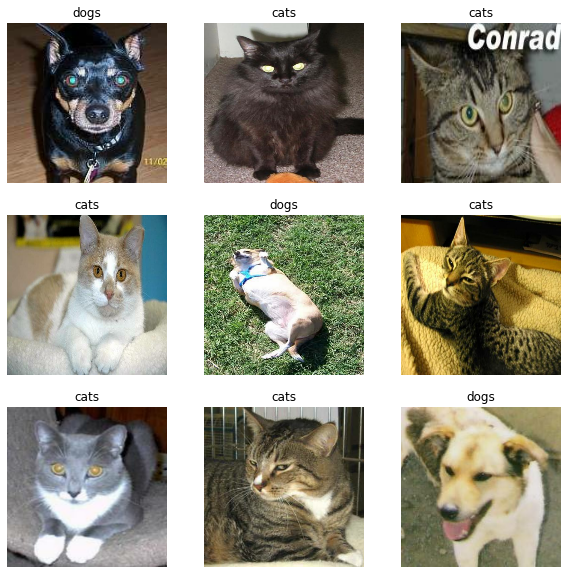

In [5]:
#viewing the two classes
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

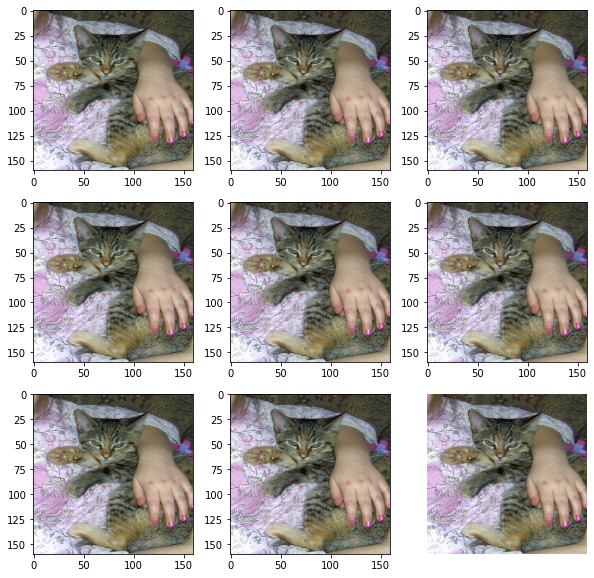

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
#preprocessing input
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [11]:
# Create the base model from the pre-trained model inceptionv3
IMG_SHAPE = IMG_SIZE + (3,)
base_model = InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87924736/87910968 [==============================] - 2s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


In [14]:
base_model.trainable = False

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 130ms/step - loss: 1.8109 - accuracy: 0.5037


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.81
initial accuracy: 0.50


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 17s 167ms/step - loss: 1.0071 - accuracy: 0.5675 - val_loss: 0.5825 - val_accuracy: 0.6832
Epoch 2/10
63/63 [==============================] - 10s 149ms/step - loss: 0.6339 - accuracy: 0.6990 - val_loss: 0.3576 - val_accuracy: 0.8267
Epoch 3/10
63/63 [==============================] - 10s 150ms/step - loss: 0.4776 - accuracy: 0.7720 - val_loss: 0.2667 - val_accuracy: 0.8985
Epoch 4/10
63/63 [==============================] - 10s 151ms/step - loss: 0.3879 - accuracy: 0.8060 - val_loss: 0.2129 - val_accuracy: 0.9022
Epoch 5/10
63/63 [==============================] - 10s 151ms/step - loss: 0.3642 - accuracy: 0.8320 - val_loss: 0.1799 - val_accuracy: 0.9295
Epoch 6/10
63/63 [==============================] - 10s 152ms/step - loss: 0.3199 - accuracy: 0.8615 - val_loss: 0.1663 - val_accuracy: 0.9344
Epoch 7/10
63/63 [==============================] - 10s 151ms/step - loss: 0.3256 - accuracy: 0.8525 - val_loss: 0.1474 - val_accuracy: 0.9369

In [22]:
model = VGG16(weights='imagenet')
model.compile()

553476096/553467096 [==============================] - 11s 0us/step


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
model.save('model.h5')